# **IMAGE ANALYSIS**
## **Practice 4.** Set Mathematical Morphology.

#### Created by: Bryan Israel Blancas Pérez.

##### ID: 2016630031

##### Group: 3CV7

## Set Mathematical Morphology

The basis of set mathematical morphology is the application of set operations to images and their operators, this is used for treatment of binary images. Also, in set mathematical morphology (also known as binary morphology) people try to probe an image with a simple, pre-defined shape, drawing conclusions on how this shape fits or misses the shapes in the image. 
To do that, in this branch of Image Analysis, the images studied are seen as a set. For example, an image with all his pixels equal to 1 which size is 2x2, will be seen as a set A = {(0,0), (0,1), (1,0), (1,1)}. In other words, set will be conformed by all the coordinates from the pixel which value is equal to 1.

This approach has the following features:

<ul>
    <li>Uses a set-theoretic approach to modify shapes based on local operators</li>
    <li>Many operations are similar to convolution but use set operations</li>
    <li>Useful for enhancing structural properties, segmentation and quantitative description</li>
</ul>

    
### Operations

Then, you will find the definition of Set Mathematical Morphology operations and bellow you will find the code and real functional examples. 

#### Operation 1. **Union**
Union operation here is just to get together two images.
Union operation is defined as follows:

<img src="theoryImages/union.png" alt="header" style="height:70px;">

#### Operation 2. **Intersection**
Intersection here is just to get only those pixels that bellongs to both images.
Intersection operation is defined as follows:

<img src="theoryImages/intersection.png" alt="header" style="height:70px;">

#### Operation 3. **Complement**
Complement operation will change every pixel to the opposite value.
Complement operation is defined as follows:

<img src="theoryImages/complement.png" alt="header" style="height:70px;">

#### Operation 4. **Traslation**
Traslation litteraly translate each pixel of the image.
Traslation operation is defined as follows:

<img src="theoryImages/traslation.png" alt="header" style="height:70px;">

#### Operation 5. **Reflection**
Reflection will make that the image pixels reflected over origin.
Reflection operation is defined as follows:

<img src="theoryImages/reflection.png" alt="header" style="height:70px;">

#### Operation 6. **Dilate**
If B has a center on the origin, as before, then the dilation of A by B can be understood as the locus of the points covered by B when the center of B moves inside A.

Dilate operation is defined as follows, where B is an structure element and this operation can be defined in three ways:

<img src="theoryImages/dilate.png" alt="header" style="width:450px;">

#### Operation 7. **Erode**
When the structuring element B has a center (e.g., B is a disk or a square), and this center is located on the origin of E, then the erosion of A by B can be understood as the locus of points reached by the center of B when B moves inside A.

Erode operation is defined as follows, where B is an structure element and this operation can be defined in two ways:

<img src="theoryImages/erode.png" alt="header" style="height:150px;">

### Relation between dilate and erode.
Exists a relation between these two operations given by:

<img src="theoryImages/relation.png" alt="header" style="height:130;">

### Especial operations
There are two operations which are obtained from seven main operations shown above. 

#### Opening
The opening of A by B is obtained by the erosion of A by B, followed by dilation of the resulting image by B. This is used to remove the salt noise.

<img src="theoryImages/opening.png" alt="header" style="height:100;">

#### Closing
The closing of A by B is obtained by the dilation of A by B, followed by erosion of the resulting structure by B:. This is used to remove the pepper noise.

<img src="theoryImages/closing.png" alt="header" style="height:100;">


## Distance Transform

The distance transform is an operator normally only applied to binary images. The result of the transform is a graylevel image that looks similar to the input image, except that the graylevel intensities of points inside foreground regions are changed to show the distance to the closest boundary from each point.

<img src="theoryImages/distanceTransform.gif" alt="header" style="width:300;">

In this practice, I used a two passes algorithm that can give us the distance transform of an image in a efficent way. This algorithm is shown bellow for 4 neighbours structured element.

<img src="theoryImages/structuredElement.png" alt="header" style="width:300;">

<ol>
    <li>Choose a metric. (In this practice there are two metrics available 4neighbors and 8neighbors)</li>
    <li>Step 1. From top to bottom and left to right.
        <ol>
            <li>
                If the current pixel of the image (A) is 0, then, the current pixel of the Distance Transform (TD) is 0.<br><img src="theoryImages/step1.1.png" alt="header" style="width:100;">
            </li>
            <li>
                If the current pixel of the image (A) is different off 0, then, the current pixel of the Distance Transform (TD) the less value of the neighbors plus 1.<br><img src="theoryImages/step1.2.png" alt="header" style="width:100;">
            </li>
        </ol>
    </li>
    <li>Step 2. From bottom to top and right to left.
        <ol>
            <li>
                If the current pixel of the image (A) is 0, then, the current pixel of the Distance Transform (TD) is 0.<br><img src="theoryImages/step1.1.png" alt="header" style="width:100;">
            </li>
            <li>
                If the current pixel of the image (A) is different off 0, then, the current pixel of the Distance Transform (TD) the less value of the neighbors plus 1 minimun current value.<br><img src="theoryImages/step2.2.png" alt="header" style="height:80px;">
            </li>
        </ol>
    </li>
</ol>


The objective of calculating the Distance Transform in this practice is be able to have an algorithm that get the erotion and dilate whose computational complexity is constant no matter the size. 


Once I have obtained the Distance Transform of an image only is necessary to do a thresholding to get the erotion or dilate of the image.

#### Erode with Distance Transform

<img src="theoryImages/erodetd.png" alt="header" style="height:115px;">

#### Dilate with Distance Transform

Important: to do dilate with DT, you must calculate de Distance Transform to the complement of the image.

<img src="theoryImages/dilatetd.png" alt="header" style="height:115px;">


## Code

**1. Import <a href="https://numpy.org">NumPy</a>, <a href="https://matplotlib.org">matplotlib</a> and Image from <a href="https://pillow.readthedocs.io/en/stable/">PIL</a>**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from PIL import Image
from time import time

**2. Load Cython extension**

In [2]:
# Load cython
%load_ext Cython

**3. Implementation of auxiliar functions and operations of Set Mathematical Morphology**

In [3]:
%%cython -a
cimport numpy as cnp
import numpy as np
import random

#
# Function that validates that the size of two images are equal 
#

def validateSize(cnp.ndarray[cnp.npy_uint8, ndim=3] image1, cnp.ndarray[cnp.npy_uint8, ndim=3] image2):
    if(image1.shape[0] != image2.shape[0]):
        return False
    elif(image1.shape[1] != image2.shape[1]):
        return False
    return True

#
# Function that remove channels 2 and 3 of an image if they exist
#

def removeChannels(cnp.ndarray[cnp.npy_uint8, ndim=3] image):
    cdef int height = image.shape[0]
    cdef int width = image.shape[1]
    cdef binary_image = np.zeros((height,width), dtype = np.uint8)
    cdef int i
    cdef int j
    
    for i in range(height):
        for j in range(width):
            binary_image[i,j] = image[i,j,0]

    return binary_image

#
# Function that do the thresholding with T
#

def thresholding(cnp.ndarray[cnp.npy_uint8, ndim=2] image, unsigned short T):   
    cdef arr = image.copy()
    cdef int height = image.shape[0]
    cdef int width = image.shape[1]
    cdef int channels = 1
    cdef int i
    cdef int j
    
    for i in range(height):
        for j in range(width):          
            if( arr[i,j] <= T):
                arr[i,j] = 0
            else:
                arr[i,j] = 255
       
    return arr

#
# Function that calculate the thresholding for dilate operation with Distance Transform
#

def dilateThresholding(cnp.ndarray[cnp.npy_uint8, ndim=2] image, unsigned short T):   
    cdef arr = image.copy()
    cdef int height = image.shape[0]
    cdef int width = image.shape[1]
    cdef int channels = 1
    cdef int i
    cdef int j
    
    for i in range(height):
        for j in range(width):          
            if( arr[i,j] <= T):
                arr[i,j] = 255
            else:
                arr[i,j] = 0
       
    return arr

#
# Function that return the set of an image
#

def getSet(cnp.ndarray[cnp.npy_uint8, ndim=2] bimage, list start):
    cdef int height = bimage.shape[0]
    cdef int width = bimage.shape[1]
    cdef int offset_h = start[0]
    cdef int offset_w = start[1]
    cdef list bset = []
    cdef int i 
    cdef int j
    
    for i in range(height):
        for j in range(width):
            if(bimage[i,j] == 1):
                bset.append([i - offset_h, j - offset_w])
            elif(bimage[i,j] == 255):
                bset.append([i - offset_h, j - offset_w])
    return bset

#
# Function that compute a set given into a image format depending of the start of the image
#

def compute_set_to_image(cnp.ndarray[cnp.npy_uint8, ndim=2] bimage, list bset, list start):
    cdef int height = bimage.shape[0]
    cdef int width = bimage.shape[1]
    cdef int offset_h = start[0]
    cdef int offset_w = start[1]
    cdef rtn_image = np.zeros((height, width), dtype=np.uint8)
    cdef list tupla
    
    for tupla in bset:
        i = tupla[0] + offset_h
        j = tupla[1] + offset_w
        if(not ((i < 0 or i >= height) or (j < 0 or j >= width))):
            rtn_image[i, j] = 255
    return rtn_image

#
# Function that compute a set given into a mask format depending of the start of the mask
#

def compute_set_to_image_mask(cnp.ndarray[cnp.npy_uint8, ndim=2] bimage, list bset, list start):
    cdef int height = bimage.shape[0]
    cdef int width = bimage.shape[1]
    cdef int offset_h = start[0]
    cdef int offset_w = start[1]
    cdef rtn_image = np.zeros((height, width), dtype=np.uint8)
    cdef list tupla
    
    for tupla in bset:
        i = tupla[0] + offset_h
        j = tupla[1] + offset_w
        if(not ((i < 0 or i >= height) or (j < 0 or j >= width))):
            rtn_image[i, j] = 1

    return rtn_image

#
# Function that put salt noise on an image depending of the percent givin
#

def putSaltNoise(cnp.ndarray[cnp.npy_uint8, ndim=2] bimage, int percent):
    cdef int height = bimage.shape[0]
    cdef int width = bimage.shape[1]

    cdef int p = int((height*width*percent)/100)

    cdef rtn = bimage.copy()
    for i in range(p):
        x = random.randint(0, height-1)
        y = random.randint(0, width-1)
        rtn[x, y] = int(255)
    return rtn

#
# Union operation implementation
#

def union(cnp.ndarray[cnp.npy_uint8, ndim=2] bimage1, cnp.ndarray[cnp.npy_uint8, ndim=2] bimage2):
    return bimage1 | bimage2

#
# Intersection operation implementation
#

def intersection(cnp.ndarray[cnp.npy_uint8, ndim=2] bimage1, cnp.ndarray[cnp.npy_uint8, ndim=2] bimage2):
    return bimage1 & bimage2

#
# Complement operation implementation
#

def complement(cnp.ndarray[cnp.npy_uint8, ndim=2] bimage):
    return bimage^0xff

#
# Traslation operation implementation
#

def traslation(list bset, list b):
    cdef list rtn_bset = []
    cdef int i 
    
    for i in range(len(bset)):
        tupla = bset[i]
        rtn_bset.append([tupla[0] + b[0], tupla[1] + b[1]])
    
    return rtn_bset

#
# Reflection operation implementation
#

def reflection(list bset):
    cdef list bset_reflected = []
    cdef list tupla
    
    for tupla in bset:
        bset_reflected.append([tupla[0] * -1, tupla[1] * -1])
        
    return bset_reflected

#
# Auxiliar function that do the intersection for dilate
#

def intersection_for_dilate(cnp.ndarray[cnp.npy_uint8, ndim=2] bimage, list b_reflected_traslated):
    cdef int height = bimage.shape[0]
    cdef int width = bimage.shape[1]
    cdef list tupla 
    
    for tupla in b_reflected_traslated:
        if(tupla[0] < 0 or tupla[0] >= height):
            continue
        if(tupla[1] < 0 or tupla[1] >= width):
            continue
        if(bimage[tupla[0], tupla[1]] == 255):
            return True
    
    return False

#
# Dilate operation implementation
#

def dilate(cnp.ndarray[cnp.npy_uint8, ndim=2] bimage, list B_reflected):
    cdef int height = bimage.shape[0]
    cdef int width = bimage.shape[1]
    cdef rtn_image = np.zeros((height, width), dtype=np.uint8)
    cdef int i 
                       
    for i in range(height):
        for j in range(width):
            b_reflected_traslated = traslation(B_reflected, [i,j])
            if(intersection_for_dilate(bimage, b_reflected_traslated) == True):
                rtn_image[i, j] = 255

    return rtn_image

#
# Auxiliar function that return it a set is a subset of bimage, for erode
#

def subset_for_erode(cnp.ndarray[cnp.npy_uint8, ndim=2] bimage, list b_traslated):
    cdef int height = bimage.shape[0]
    cdef int width = bimage.shape[1]
    cdef list tupla
    
    for tupla in b_traslated:
        if(tupla[0] < 0 or tupla[0] >= height):
            return False
        if(tupla[1] < 0 or tupla[1] >= width):
            return False
        if(bimage[tupla[0], tupla[1]] != 255):
            return False
        
    return True

#
# Erode operation implementation
#

def erode(cnp.ndarray[cnp.npy_uint8, ndim=2] bimage, list B):
    cdef int height = bimage.shape[0]
    cdef int width = bimage.shape[1]
    cdef rtn_image = np.zeros((height, width), dtype=np.uint8)
    cdef int i 
    
    for i in range(height):
        for j in range(width):
            b_traslated = traslation(B, [i,j])
            if(subset_for_erode(bimage, b_traslated) == True):
                rtn_image[i, j] = 255

    return rtn_image

#
# Functions that calculate the distance transform of a given image (4 NEIGHBOURS)
#

def distanceTransform_4N(cnp.ndarray[cnp.npy_uint8, ndim=2] bimage):
    cdef int height = bimage.shape[0]
    cdef int width = bimage.shape[1]
    cdef int offset_h = 1
    cdef int offset_w = 1

    cdef distanceTransform = np.zeros((height+2, width+2), dtype = np.uint8)
    cdef distanceTransform_final = np.zeros((height, width), dtype = np.uint8)

    distanceTransform[0, :] = 254
    distanceTransform[height+offset_h, :] = 254
    distanceTransform[:, 0] = 254
    distanceTransform[:, width+offset_w] = 254

    cdef int i
    cdef int j
    
    for i in range(height):
        for j in range(width):
            if(bimage[i, j] != 0):
                new_i = i+offset_h
                new_j = j+offset_w
                value = min(distanceTransform[i, new_j], distanceTransform[new_i, j])+1
                if(value > 255):
                    value = 255
                distanceTransform[new_i, new_j] = value

    for i in range(height-1, -1, -1):
        for j in range(width-1, -1, -1):
            if(bimage[i,j] != 0):
                new_i = i+offset_h
                new_j = j+offset_w
                value = min(distanceTransform[new_i+1, new_j], distanceTransform[new_i, new_j+1]) + 1
                value = min(value,  distanceTransform[new_i, new_j])
                if(value > 255):
                    value = 255
                distanceTransform[new_i, new_j] = value
                distanceTransform_final[i,j] = value

    return distanceTransform_final

#
# Functions that calculate the distance transform of a given image (8 NEIGHBOURS)
#

def distanceTransform_8N(cnp.ndarray[cnp.npy_uint8, ndim=2] bimage):
    cdef int height = bimage.shape[0]
    cdef int width = bimage.shape[1]
    cdef int offset_h = 1
    cdef int offset_w = 1

    cdef distanceTransform = np.zeros((height+2, width+2), dtype = np.uint8)
    cdef distanceTransform_final = np.zeros((height, width), dtype = np.uint8)

    distanceTransform[0, :] = 255
    distanceTransform[height+offset_h, :] = 255
    distanceTransform[:, 0] = 255
    distanceTransform[:, width+offset_w] = 255
    
    cdef int i
    cdef int j
    
    for i in range(height):
        for j in range(width):
            if(bimage[i, j] != 0):
                new_i = i+offset_h
                new_j = j+offset_w
                value = min(distanceTransform[i, new_j], distanceTransform[new_i, j], distanceTransform[i, j], distanceTransform[i, new_j+1]) + 1
                if(value > 255):
                    value = 255
                distanceTransform[new_i, new_j] = value

    for i in range(height-1, -1, -1):
        for j in range(width-1, -1, -1):
            if(bimage[i,j] != 0):
                new_i = i+offset_h
                new_j = j+offset_w
                value = min(distanceTransform[new_i+1, new_j], distanceTransform[new_i, new_j+1], distanceTransform[new_i+1, new_j+1], distanceTransform[new_i+1, j]) + 1
                value = min(value,  distanceTransform[new_i, new_j])
                if(value > 255):
                    value = 255
                distanceTransform[new_i, new_j] = value
                distanceTransform_final[i,j] = value

    return distanceTransform_final

**4. Reading and preparing images**

In [4]:
# Name of both images
binary_image1_name = "./binary/a_binary.png"
binary_image2_name = "./binary/b_binary.png"

# Reading both images
binary_image1 = Image.open(binary_image1_name)
binary_image2 = Image.open(binary_image2_name)

# Cast both images into numpy array
binary_image1_array = np.asarray(binary_image1)
binary_image2_array = np.asarray(binary_image2)

# Validate size of both images
if(validateSize(binary_image1_array, binary_image2_array) != True):
    sys.exit("Images are different size "+str(binary_image1_array.shape)+" vs "+str(binary_image2_array.shape))

# Remove extra channels of both images
bimage1 = removeChannels(binary_image1_array)
bimage2 = removeChannels(binary_image2_array)

# Cast both images into binary images
bimage1 = thresholding(bimage1, 125)
bimage2 = thresholding(bimage2, 125)

# Put salt noise into image
bimage1 = putSaltNoise(bimage1, 10)

**5. Union** 



Calculating union...
CPU times: user 881 µs, sys: 57 µs, total: 938 µs
Wall time: 796 µs


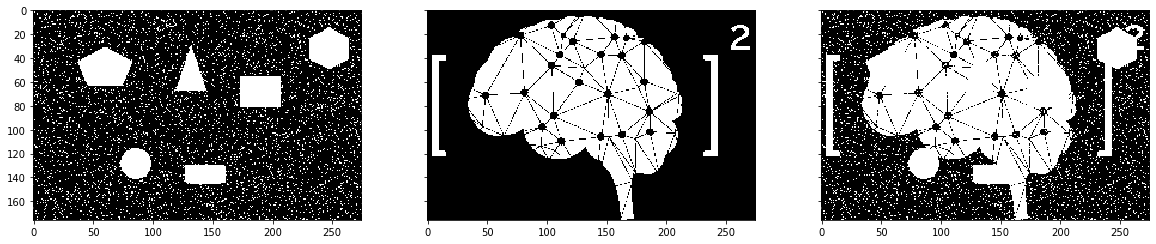

In [5]:
print("\n\nCalculating union...")
%time bunion = union(bimage1, bimage2)

f, axarr = plt.subplots(1,3, figsize=(20,20), sharey=True)
axarr[0].imshow(bimage1, cmap = 'gray')
axarr[1].imshow(bimage2, cmap = 'gray')
axarr[2].imshow(bunion, cmap = 'gray')
plt.show()

**6. Intersection**



Calculating intersection...
CPU times: user 357 µs, sys: 18 µs, total: 375 µs
Wall time: 297 µs


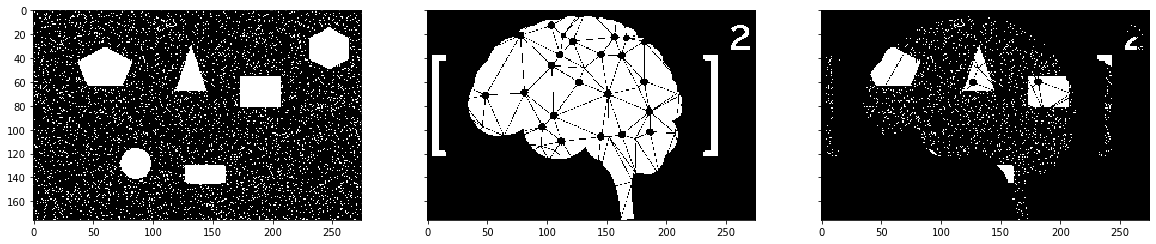

In [6]:
print("\n\nCalculating intersection...")
%time bintersection = intersection(bimage1, bimage2)

f, axarr = plt.subplots(1,3, figsize=(20,20), sharey=True)
axarr[0].imshow(bimage1, cmap = 'gray')
axarr[1].imshow(bimage2, cmap = 'gray')
axarr[2].imshow(bintersection, cmap = 'gray')
plt.show()

**7. Complement**



Calculating complement...
CPU times: user 823 µs, sys: 36 µs, total: 859 µs
Wall time: 813 µs


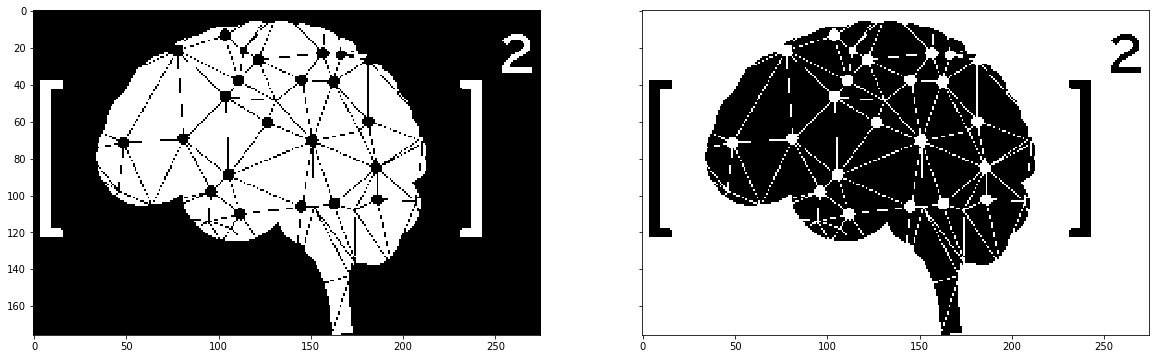

In [7]:
print("\n\nCalculating complement...")
%time bcomplement = complement(bimage2)

f, axarr = plt.subplots(1,2, figsize=(20,20), sharey=True)
axarr[0].imshow(bimage2, cmap = 'gray')
axarr[1].imshow(bcomplement, cmap = 'gray')
plt.show()

**8. Traslation**



Calculating traslation...
CPU times: user 6.1 ms, sys: 0 ns, total: 6.1 ms
Wall time: 6.11 ms


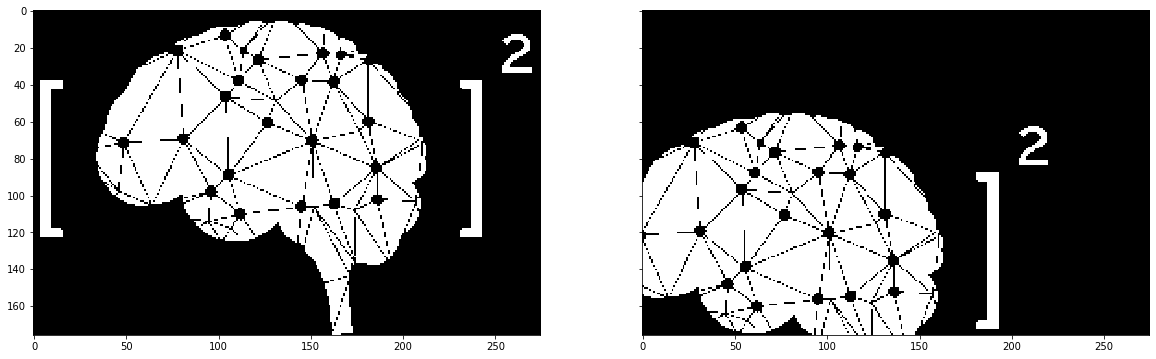

In [8]:
print("\n\nCalculating traslation...")
b = [50, -50]
start_of_image = [0,0]
bimage2_set = getSet(bimage2, start_of_image)
%time btraslation_set = traslation(bimage2_set, b)
btraslation_image = compute_set_to_image(bimage2, btraslation_set, start_of_image)

f, axarr = plt.subplots(1,2, figsize=(20,20), sharey=True)
axarr[0].imshow(bimage2, cmap = 'gray')
axarr[1].imshow(btraslation_image, cmap = 'gray')
plt.show()

**9. Reflection**



Calculating reflection...
CPU times: user 14.7 ms, sys: 8.08 ms, total: 22.8 ms
Wall time: 11.8 ms


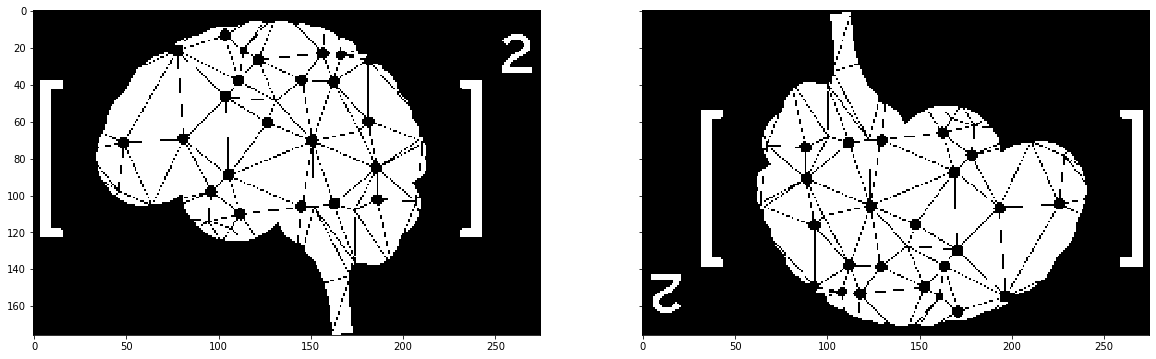

In [9]:
print("\n\nCalculating reflection...")
start_of_image = [88,137]
bimage2_set = getSet(bimage2, start_of_image)
%time breflection_set = reflection(bimage2_set)
breflection_image = compute_set_to_image(bimage2, breflection_set, start_of_image)

f, axarr = plt.subplots(1,2, figsize=(20,20), sharey=True)
axarr[0].imshow(bimage2, cmap = 'gray')
axarr[1].imshow(breflection_image, cmap = 'gray')
plt.show()

**10. Dilate**



Calculating dilate...
CPU times: user 1.58 s, sys: 11.7 ms, total: 1.6 s
Wall time: 1.58 s


	Calculating dilate with distance transform...
	 1. DistanceTransform
	 2. Dilate with DT
CPU times: user 1.24 s, sys: 4.07 ms, total: 1.24 s
Wall time: 1.25 s
CPU times: user 401 ms, sys: 0 ns, total: 401 ms
Wall time: 400 ms


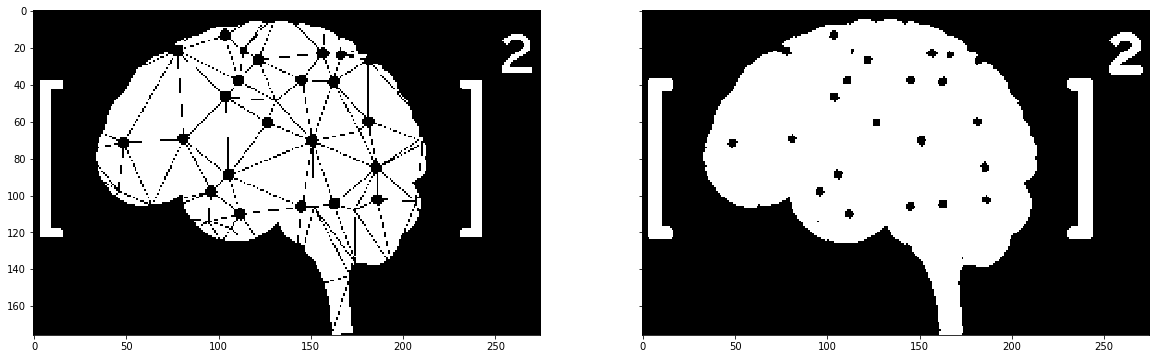

In [10]:
print("\n\nCalculating dilate...")
start_of_image = [0,0]
B = np.array([
    [0,1,0],
    [1,1,1],
    [0,1,0]
], dtype = np.uint8)
start_B = [1,1]

B_set = getSet(B, start_B)
B_reflected = reflection(B_set)
%time bdilate_image = dilate(bimage2, B_reflected)

print("\n\n\tCalculating dilate with distance transform...\n\t 1. DistanceTransform\n\t 2. Dilate with DT")
%time distanceTransform = distanceTransform_4N(bcomplement)
%time bdilate_image = dilateThresholding(distanceTransform, 1)

f, axarr = plt.subplots(1,2, figsize=(20,20), sharey=True)
axarr[0].imshow(bimage2, cmap = 'gray')
axarr[1].imshow(bdilate_image, cmap = 'gray')
plt.show()

**11. Erode**



Calculating erode...
CPU times: user 1.14 s, sys: 11.9 ms, total: 1.16 s
Wall time: 1.13 s


	Calculating erode with distance transform...
	 1. DistanceTransform
	 2. Erode with DT
CPU times: user 654 ms, sys: 8.06 ms, total: 662 ms
Wall time: 653 ms
CPU times: user 365 ms, sys: 0 ns, total: 365 ms
Wall time: 364 ms


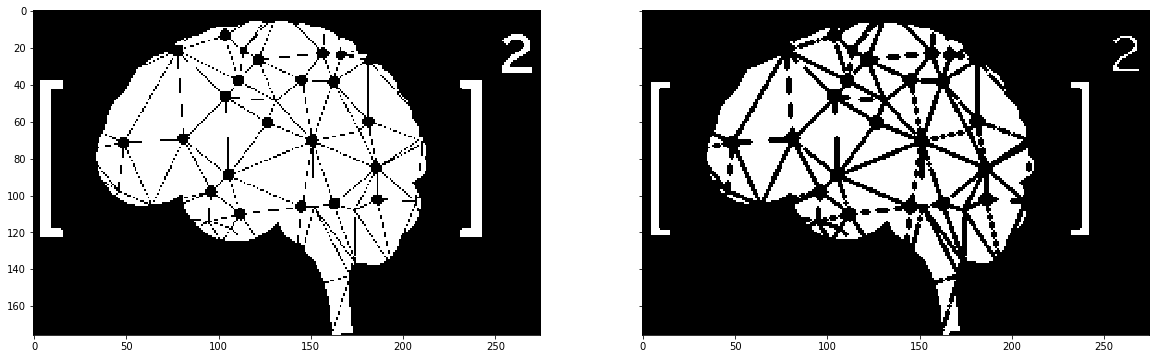

In [11]:
print("\n\nCalculating erode...")

B = np.array([
    [0,1,0],
    [1,1,1],
    [0,1,0]
], dtype = np.uint8)
start_B = [1,1]

B_set = getSet(B, start_B)
%time berode_image = erode(bimage2, B_set)

print("\n\n\tCalculating erode with distance transform...\n\t 1. DistanceTransform\n\t 2. Erode with DT")
%time distanceTransform = distanceTransform_4N(bimage2)
%time berode_image = thresholding(distanceTransform, 1)

f, axarr = plt.subplots(1,2, figsize=(20,20), sharey=True)
axarr[0].imshow(bimage2, cmap = 'gray')
axarr[1].imshow(berode_image, cmap = 'gray')
plt.show()

**12. Opening**



Calculating opening...
CPU times: user 960 ms, sys: 107 µs, total: 960 ms
Wall time: 951 ms
CPU times: user 3.55 s, sys: 20 ms, total: 3.57 s
Wall time: 3.54 s


	Calculating opening transform 4 neighbours... 
	 1. Dilance transform bimage1 
	 2. Erode DT 
	 3. Complemente Erode DT 
	 4. DT de Erode DT 
	 5. Dilate DT
CPU times: user 328 ms, sys: 4.07 ms, total: 332 ms
Wall time: 327 ms
CPU times: user 403 ms, sys: 0 ns, total: 403 ms
Wall time: 402 ms
CPU times: user 1.24 ms, sys: 0 ns, total: 1.24 ms
Wall time: 1.26 ms
CPU times: user 1.99 s, sys: 24.1 ms, total: 2.02 s
Wall time: 2.02 s
CPU times: user 371 ms, sys: 0 ns, total: 371 ms
Wall time: 370 ms


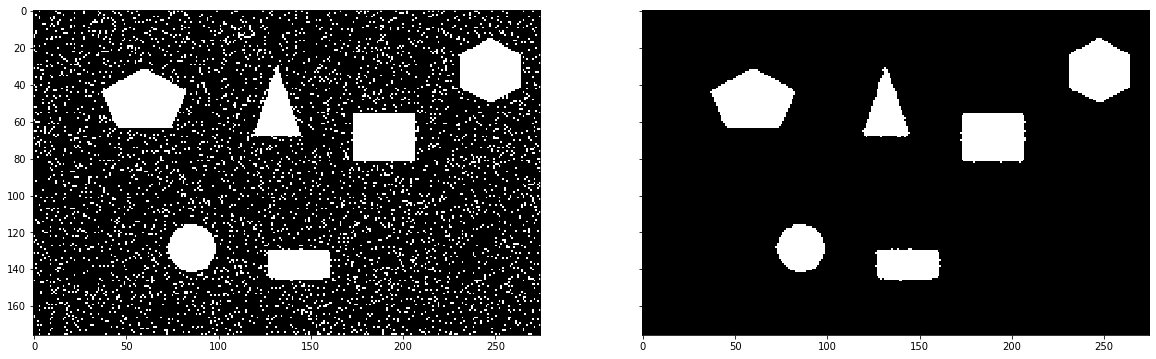

In [12]:
B = np.array([
    [1,1,1],
    [1,1,1],
    [1,1,1]
], dtype = np.uint8)
B_start = [1,1]

B_set = getSet(B, B_start)
B_reflected = reflection(B_set)

print("\n\nCalculating opening...")
%time opening_erode = erode(bimage1, B_set)
%time opening = dilate(opening_erode, B_reflected)

print("\n\n\tCalculating opening transform 4 neighbours... \n\t 1. Dilance transform bimage1 \n\t 2. Erode DT \n\t 3. Complemente Erode DT \n\t 4. DT de Erode DT \n\t 5. Dilate DT")
%time distanceTransform = distanceTransform_4N(bimage1)
%time opening_erode = thresholding(distanceTransform, 1)
%time opening_erode = complement(opening_erode)
%time distanceTransform = distanceTransform_4N(opening_erode)
%time opening = dilateThresholding(distanceTransform, 1)

f, axarr = plt.subplots(1,2, figsize=(20,20), sharey=True)
axarr[0].imshow(bimage1, cmap = 'gray')
axarr[1].imshow(opening, cmap = 'gray')
plt.show()

## Conclusions

This practice was really interesting for me because I could see the importance of a good mathematical bases. For me was exiting applied some mathematical concepts as well as mathematical analysis.

I have few of problems while I was developing the 4 neighbours algorithm but after some good lessons I was able to fix that problems and finished my practice

Also with the implementation of distance transform I could see that it is worth looking for an optimal way to do something, to get the most out of current computing.